<a href="https://colab.research.google.com/github/statscol/Embeddings-end-to-end/blob/main/Bert_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.4 MB 14.5 MB/s 


In [4]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.8 MB 14.7 MB/s 
     |████████████████████████████████| 1.2 MB 70.2 MB/s 
     |████████████████████████████████| 352 kB 71.5 MB/s 
     |████████████████████████████████| 1.1 MB 50.2 MB/s 
     |████████████████████████████████| 99 kB 7.8 MB/s 
     |████████████████████████████████| 90 kB 9.7 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 211 kB 56.1 MB/s 
     |████████████████████████████████| 636 kB 55.7 MB/s 


In [5]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

### Sentiment Analysis
We want to predict the polarity of a user review using its raw text. 



In [6]:
reviews=pd.read_csv("challenge_data.csv")
reviews.head()

,Unnamed: 0,text,tag
0,0,"in exotica everybody is watching , and what is...",pos
1,1,some of the gags are so carefully innocuous th...,neg
2,2,press junkets are a haven for control freaks .,neg
3,3,"then i realized he was , and i was watching it .",neg
4,4,uh huh .,neg


## Data Wrangling
let's clean data and change pos and neg labels to integers

In [7]:
##check whether or not we have null values

np.sum(reviews.isnull(),axis=0)

Unnamed: 0     0
text          17
tag            8
dtype: int64

In [8]:
## for now lets get rid of those reviews which do not have a tag available and fill null reviews with "" 

reviews=reviews[~reviews.tag.isna()]
reviews.text.fillna("",inplace=True)

In [9]:
#check out dataset
np.sum(reviews.isnull(),axis=0)

Unnamed: 0    0
text          0
tag           0
dtype: int64

In [10]:
reviews['label']=reviews['tag'].apply(lambda k: 0 if k=='neg' else 1)

## EDA

Positive reviews are far less than negative ones, this will be a problem when training a model given that performance metric are sentitive to class imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


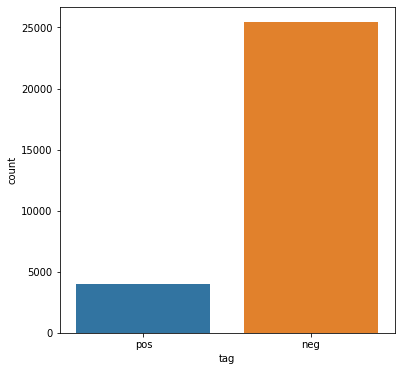

In [ ]:
f,ax=plt.subplots(figsize=(6,6))
sns.countplot("tag",data=reviews,ax=ax);

In [11]:
### use external data 

##what if we include external reviews to increase minority class?
##lets use Imdb data and keras data api to get data
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=50000, seed=123)


for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['text', 'label']
train['text'] = train['text'].str.decode("utf-8")
##we're only interested in positive comments
positive_external=train[train['label']==1]

###include external data
reviews=pd.concat([reviews[['text','label']],positive_external])


84140032/84125825 [==============================] - 6s 0us/step
Found 75000 files belonging to 3 classes.


In [12]:
##remove special characters and use lowerCase only

import re

def remove_special(str1):
  str_aux= str1.replace('<br>', "")
  str_aux= str_aux.replace('</br>', "")
  str_aux=re.sub(r"[^a-zA-Z0-9]"," ",str_aux).lower()
  str_aux=re.sub('\s+', ' ',str_aux).strip()
  return str_aux

reviews['text']=reviews['text'].apply(lambda d: remove_special(d))


In [ ]:
print( "Majority to minority class relation : " , np.round(sum(reviews.label==0)/sum(reviews.label==1),1))

Majority to minority class relation :  2.1



# Approach No.2

Using BERT Pre trained embeddings to build a classifier

In [13]:
model_url='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
preprocess_ulr='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(preprocess_ulr)
bert_model = hub.KerasLayer(model_url)

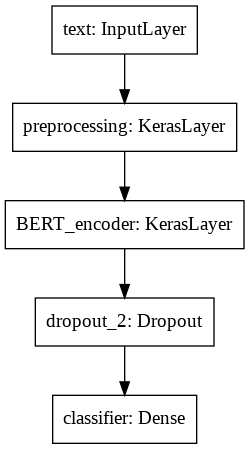

In [16]:
##now lets use the preprocessing and bert  together in a model
def build_classifier_model(preprocess_ulr,model_url):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_ulr, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_url, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model(preprocess_ulr,model_url)
tf.keras.utils.plot_model(classifier_model) ##graph 

### Prepare Data for BERT

In [17]:
## divide data on train-test 80%-20%

from sklearn.model_selection import train_test_split

labels=reviews.label.values.astype('int64')
train,test = train_test_split(reviews, test_size=0.2, random_state=123)
print("Reviews for training: {} \nReviews for testing: {}".format(train.shape[0],test.shape[0]))

Reviews for training: 30186 
Reviews for testing: 7547


In [18]:
def convert_to_tf_data(df):

  dataset = (
      tf.data.Dataset.from_tensor_slices(
          (
              tf.cast(df['text'].values, tf.string),
              tf.cast(df['label'].values.astype('int64'), tf.int64)
          )
      )
  )
  return dataset
batch_size = 32
train_ds=convert_to_tf_data(train)
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size)
test_ds=convert_to_tf_data(test)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size)


## Train Model

## Define & train the model

We'll be using Keras functional API to train a classifier. Callbacks to avoid overfitting are also provided in the process

In [19]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [20]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [21]:
##define class weights for imbalanced data
n_classes=np.unique(train.label).shape[0]
neg_weight = (1 / sum(train.label==0)) * (train.shape[0] / n_classes)  ##according to TF, scale by number of classes
pos_weight = (1 / sum(train.label==1)) * (train.shape[0] / n_classes)

class_weight = {0: neg_weight, 1: pos_weight}
print(class_weight)

{0: 0.7423638778220452, 1: 1.5315068493150685}


In [22]:
tf.config.run_functions_eagerly(True) ##enable tf 2.x 

print(f'Training model with {model_url}')
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs,class_weight=class_weight)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


944/944 [==============================] - 7008s 7s/step - loss: 0.3893 - binary_accuracy: 0.8654 - val_loss: 0.3387 - val_binary_accuracy: 0.8801
Epoch 2/2
944/944 [==============================] - 6934s 7s/step - loss: 0.2912 - binary_accuracy: 0.9005 - val_loss: 0.3194 - val_binary_accuracy: 0.8744


In [24]:
##save model
from tensorflow.keras.models import load_model,save_model

classifier_model.save("/content/bert-sentiment.h5")

## Model Performance during training and final metrics on training and test data



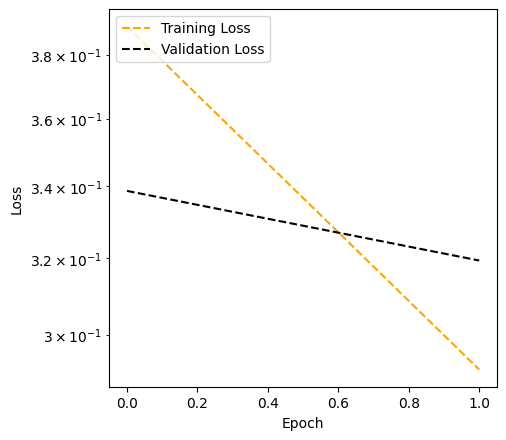

In [25]:


##Lets see the training process metrics
def plot_results(history):
  f,ax=plt.subplots(figsize=(5,5),dpi=100)
  epochs=history.epoch
  metric_tr=history.history.get('loss')
  metric_val=history.history.get('val_loss')
  plt.semilogy(epochs, metric_tr, color='orange', label='Training Loss',linestyle='--')
  plt.semilogy(epochs, metric_val, color='black', label='Validation Loss',linestyle='--')
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  plt.legend(loc="upper left")
plot_results(history=history)  

In [26]:
##Function to compute metrics 
from sklearn.metrics import cohen_kappa_score,accuracy_score,f1_score,precision_score,recall_score,make_scorer
def metrics(real,pred):
  kappa=cohen_kappa_score(real,pred)
  acc=accuracy_score(real,pred)
  f1=f1_score(real,pred)
  prec=precision_score(real,pred)
  recall=recall_score(real,pred)

  print (f" Accuracy:{acc:.4f} \n Precision: {prec:.4f} \n Recall: {recall:.4f} \n Kappa: {kappa:.4f} \n F1-Score: {f1:.4f} ")


In [42]:
classifier_model.predict(["i like this movie"," ever seen a better product than this"])

array([[0.14823368],
       [0.08955529]], dtype=float32)

In [45]:
##evaluate on test data
classifier_model.evaluate(test_ds)

236/236 [==============================] - 384s 2s/step - loss: 0.3194 - binary_accuracy: 0.8744


[0.31936442852020264, 0.8743871450424194]

In [53]:
##metrics on test set
print("="*5+"TESTING"+"="*5)
y_test_pred=classifier_model.predict(test.text.values,workers=-1,verbose=1,use_multiprocessing=True)
metrics(test.label.values.astype('int64'),np.round(y_test_pred))

=====TESTING=====
 Accuracy:0.8744 
 Precision: 0.8403 
 Recall: 0.7557 
 Kappa: 0.7054 
 F1-Score: 0.7958 


## Predict on new data


In [65]:
test[test['label']==1].text.values[90]

'fragglerock is excellent in the way that schindler s list was excellent a great watch for children and adults of all genders big noses can be seen as hinting towards phallic symbols in the same way that h r puff n stuff had hinted towards marijuana smoking your kids will love this movie i enjoyed it very much as a child my father showed me this movie as a child he enjoyed it as well and pointed out that the exaggerated noses were phallic symbols although at the time i had no clue about what those were the movie is comedy and adventure the storyline is wacky and cheerful i and you shall enjoy this together'

In [68]:
##apply on new data
text_samples=["washington's subdued approach is part of the reason for this ; i never felt a sense of urgency .",
              "it's certainly not the cast , which includes enough hot , young talent for several movies .",
              "unfortunately , sandler is going to make a lot of people shrug this one off as a no-brainer , but it's got so much surprise substance packed inside that i'm encouraging everyone to go see it ."]
def get_polarity(str1):
  return(classifier_model.predict(str1))


get_polarity(text_samples)

array([[0.8254978 ],
       [0.08483678],
       [0.08341965]], dtype=float32)